# Coupled Neural Network

In this notebook we want to implement a coupled Neural Network system, but mantaining the previous functionalities (Fingerprint and or Descriptors).
The NN we want to use in this implementations are:

- NN that only uses fingerprints.
- NN that only uses descriptors.

Then we'll evaluate the test set on both trained NN and finally only consider the molecules that have been equally classified in both NN models.

In [16]:
from small_datasets_utils_coupled import *
import CYP_data_generation as CYP
import numpy as np
import numpy.testing as npt
import pandas as pd
from itertools import product
import os
from imblearn.under_sampling import RandomUnderSampler

Some inputs that need to be introduced...

In [17]:
FINGERPRINT = 'MACCS'
DESCRIPTOR = 'Mordred'
model_from_fp = 'Anna'
model_from_des = 'Anna'
use_fingerprints = True  # if true -> fingerpornts are used.
use_descriptors = True  # if true -> descriptors are used.
balance_dataset = False   # if true -> it randomly remove molecules from the biggest class with RandomUnderSampler()
coupled_NN = True  # if true -> two NN are used, one for descriptors and one for fp

do_combination = False # False to use percentil_com to choose the combinations. True to do all the combinations with percetile_descriptors_ls and percetile_fingerprint_ls

# Percentage to be kept
percetile_descriptors_ls = [10,20,40,60]
percetile_fingerprint_ls = [10,20,40,60]
# Select percentile combination. Used if do_combination=False
percentil_com = [(60,20)] # In each tuple it is indicated (percetile_fp, percentile_des)

dataset_size = 500  # training + validation sets
train_size = int(0.75 * dataset_size)
val_size = int(0.25 * dataset_size)

seed = 1
num_train_val_splits = 2 # Number of splits of the whole dataset
folds = 2 # Number of folds in cross-validation

load_clean_data = True  # Otherwise it will load data with NaN
remove_outliers = True
normalize_descriptors = True


Check if your input is valid.
If there's an exception error, please review `use_fingerprints`,`use_descriptors` and `coupled_NN` parameters.

In [18]:
if use_fingerprints and not use_descriptors:
    if coupled_NN:
        raise Exception('Invalid input. `coupled_NN` must be False if `use_fingerprints`=`use_descriptors`=True')
    print(f"Only {FINGERPRINT} fingerprints are going to be used.")
elif use_descriptors and not use_fingerprints:
    if coupled_NN:
        raise Exception('Invalid input. `coupled_NN` must be False if `use_fingerprints`=`use_descriptors`=True')
    print(f"Only {DESCRIPTOR} descriptors are going to be used.")
elif use_fingerprints and use_descriptors:
    if coupled_NN:
        print("Fingerprints and descriptors are going to be used in different NN.")
    else:
        print("Fingerprints and descriptors are going to be used (concatenated).")


Fingerprints and descriptors are going to be used in different NN.


Load all the aviable models.

In [19]:
model_fp = {
    'Morgan_Anna': {'layers_dimensions': [130, 130, 130, 130, 130, 130, 1], 'lr':0.001, 'dropout':0.2, 'optimizer':'adam', 'L2':0.001},
    'Morgan_Joan': {'layers_dimensions': [256,256,256,256,256,256,256,256,1], 'lr':0.1, 'dropout':0.2, 'optimizer':'sgd', 'L2':0.001},
    'MACCS_Anna': {'layers_dimensions': [70, 70, 70, 70, 1], 'lr':0.01, 'dropout':0.2, 'optimizer':'adam', 'L2':0.001},
    'MACCS_Joan': {'layers_dimensions': [150,150,150,150,1], 'lr':0.001, 'dropout':0.2, 'optimizer':'sgd', 'L2':0.001},
    'RDKit_Anna': {'layers_dimensions': [90, 90, 90, 90, 1], 'lr':0.1, 'dropout':0.2, 'optimizer':'sgd', 'L2':0.001},
    'RDKit_Joan': {'layers_dimensions': [130,130,130,130,1], 'lr':0.1, 'dropout':0.2, 'optimizer':'sgd', 'L2':0.001},
    }

model_des = {
    'Mordred_Anna': {'layers_dimensions': [90, 90, 90, 1], 'lr':0.001, 'dropout':0.2, 'optimizer':'RMSprop', 'L2':0.01}
    }

model_fp_des = {
    'Morgan_Mordred_Anna': {'layers_dimensions': [70, 70, 70, 1], 'lr':0.01, 'dropout':0.5, 'optimizer':'adam', 'L2':0.01},
    'MACCS_Mordred_Anna': {'layers_dimensions': [30, 30, 30, 30, 30, 1], 'lr':0.001, 'dropout':0.2, 'optimizer':'RMSprop', 'L2':0.001},
    'RDKit_Mordred_Anna': {'layers_dimensions': [30, 30, 30, 30, 1], 'lr':0.01, 'dropout':0.2, 'optimizer':'sgd', 'L2':0.001},
    }

In [20]:
np.random.seed(seed)  # set a numpy seed
rand_num = np.random.randint(10000, size=num_train_val_splits)
print(rand_num)

[ 235 5192]


In [21]:
PATH = '../' #"/gpfs/scratch/bsc72/bsc72665/" # For Power9
PATH_DATA = "../datasets/CYP/" #f"{PATH}}datasets/CYP/"
PATH_FEAT = 'features/' # f"{PATH}}2D_smaller_dataset/features"

if balance_dataset:
    if use_fingerprints and use_descriptors:
        if coupled_NN:
            PATH_SAVE = f"{PATH}2D_smaller_dataset/method_A/{FINGERPRINT}_{DESCRIPTOR}/Model_{model_from_des}/coupled/balanced_dataset/{dataset_size}molec/"
        else:
            PATH_SAVE = f"{PATH}2D_smaller_dataset/method_A/{FINGERPRINT}_{DESCRIPTOR}/Model_{model_from_des}/concatenated/balanced_dataset/{dataset_size}molec/"
    elif use_fingerprints:
        PATH_SAVE = f"{PATH}2D_smaller_dataset/method_A/{FINGERPRINT}/Model_{model_from_fp}/balanced_dataset/{dataset_size}molec/"
    else:
        PATH_SAVE = f"{PATH}2D_smaller_dataset/method_A/{DESCRIPTOR}/Model_{model_from_des}/balanced_dataset/{dataset_size}molec/"
elif not balance_dataset:
    if use_fingerprints and use_descriptors:
        if coupled_NN:
            PATH_SAVE = f"{PATH}2D_smaller_dataset/method_A/{FINGERPRINT}_{DESCRIPTOR}/Model_{model_from_des}/coupled/unbalanced_dataset/{dataset_size}molec/"
        else:
            PATH_SAVE = f"{PATH}2D_smaller_dataset/method_A/{FINGERPRINT}_{DESCRIPTOR}/Model_{model_from_des}/concatenated/unbalanced_dataset/{dataset_size}molec/"
    elif use_fingerprints:
        PATH_SAVE = f"{PATH}2D_smaller_dataset/method_A/{FINGERPRINT}/Model_{model_from_fp}/unbalanced_dataset/{dataset_size}molec/"
    else:
        PATH_SAVE = f"{PATH}2D_smaller_dataset/method_A/{DESCRIPTOR}/Model_{model_from_des}/unbalanced_dataset/{dataset_size}molec/"
PATH_CV_results = f"{PATH_SAVE}CV_results/"
PATH_confusion = f"{PATH_SAVE}confusion/"

if not os.path.exists(PATH_CV_results):
    os.makedirs(PATH_CV_results)
    
if not os.path.exists(PATH_confusion):
    os.makedirs(PATH_confusion)
    
print(PATH_SAVE)

../2D_smaller_dataset/method_A/MACCS_Mordred/Model_Anna/coupled/unbalanced_dataset/500molec/


In [22]:
shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
testing_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_testing_2c9 = (testing_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
testing_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_testing_3a4 = (testing_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

smi_col_shared = col_to_array(shared_data, 'CanonicalSMILES')
smi_col_only2c9 = col_to_array(testing_2c9_data, 'CanonicalSMILES')
smi_col_only3a4 = col_to_array(testing_3a4_data, 'CanonicalSMILES')

In [23]:
# get_fingerprints is a function that has to be changed if we change the dataset
features_shared, features_only_2c9, features_only_3a4 = CYP.get_fingerprint(FINGERPRINT, PATH_DATA, PATH_FEAT)

if load_clean_data:
    if os.path.exists(os.path.join(PATH_FEAT, "shared_set_features_mordred_clean.npy")):
        descriptors_shared = pd.read_csv(os.path.join(PATH_FEAT, "shared_set_features_mordred_clean.npy")).drop(
            ['Unnamed: 0'], axis=1)
    else:
        descriptors_shared = get_descriptors(smi_col_shared, labels_2c9, clean_dataset=True,
                                             filename='shared_set_features_mordred_clean')
    if os.path.exists(os.path.join(PATH_FEAT, "only2c9_features_mordred_clean.npy")):
        descriptors_only2c9 = pd.read_csv(os.path.join(PATH_FEAT, "only2c9_features_mordred_clean.npy")).drop(
            ['Unnamed: 0'], axis=1)
    else:
        descriptors_only2c9 = get_descriptors(smi_col_only2c9, labels_testing_2c9, clean_dataset=True,
                                              filename='only2c9_features_mordred_clean')
    #if os.path.exists(os.path.join(PATH_FEAT, "only3a4_features_mordred_clean.npy")):
    #    descriptors_only3a4 = pd.read_csv(os.path.join(PATH_FEAT, "only3a4_features_mordred_clean.npy")).drop(
    #        ['Unnamed: 0'], axis=1)
    #else:
    #    descriptors_only3a4 = get_descriptors(smi_col_only2c9, labels_testing_3a4, clean_dataset=True,
    #                                          filename='only3a4_features_mordred_clean')
    
else:
    if os.path.exists(os.path.join(PATH_FEAT, "shared_set_features_mordred.npy")):
        descriptors_shared = pd.read_csv(os.path.join(PATH_FEAT, "shared_set_features_mordred.npy")).drop(
            ['Unnamed: 0'], axis=1)
    else:
        descriptors_shared = get_descriptors(smi_col_shared, labels_2c9, clean_dataset=False,
                                             filename='shared_set_features_mordred')
    if os.path.exists(os.path.join(PATH_FEAT, "only2c9_features_mordred.npy")):
        descriptors_only2c9 = pd.read_csv(os.path.join("features", "only2c9_features_mordred.npy")).drop(['Unnamed: 0'],
                                                                                                         axis=1)
    else:
        descriptors_only2c9 = get_descriptors(smi_col_only2c9, labels_testing_2c9, clean_dataset=False,filename='only2c9_features_mordred')
    #if os.path.exists(os.path.join(PATH_FEAT, "only3a4_features_mordred.npy")):
    #    descriptors_only3a4 = pd.read_csv(os.path.join("features", "only3a4_features_mordred.npy")).drop(['Unnamed: 0'],
    #                                                                                                     axis=1)
    #else:
    #    descriptors_only3a4 = get_descriptors(smi_col_only3a4, labels_testing_3a4, clean_dataset=False,filename='only3a4_features_mordred')

In [24]:
if load_clean_data:  # To get data with the same number of descriptors (columns in this case) for the shared_dataset and the only_2c9_dataset
    lst_shared_clean = list(descriptors_shared.columns.values)
    lst_only2c9_clean = list(descriptors_only2c9.columns.values)
    #lst_only3a4_clean = list(descriptors_only3a4.columns.values)
    common_elements = list(set(lst_shared_clean) & set(lst_only2c9_clean))

    lst_shared_clean = list(set(lst_shared_clean) - set(common_elements))
    lst_only2c9_clean = list(set(lst_only2c9_clean) - set(common_elements))
    #lst_only3a4_clean = list(set(lst_only3a4_clean) - set(common_elements))

    descriptors_shared = descriptors_shared.drop(lst_shared_clean, axis=1)
    descriptors_only2c9 = descriptors_only2c9.drop(lst_only2c9_clean, axis=1)
    #descriptors_only3a4 = descriptors_only3a4.drop(lst_only3a4_clean, axis=1)

assert descriptors_shared.shape[1] == descriptors_only2c9.shape[1]

In [25]:
if remove_outliers:
    threshold = 3
    if not os.path.exists(os.path.join(PATH_FEAT, "shared_set_features_mordred_clean_no_outliers.npy")):
        descriptors_shared = drop_outliers(descriptors_shared, threshold=threshold)
        descriptors_shared.to_csv(os.path.join(PATH_FEAT, 'shared_set_features_mordred_clean_no_outliers.npy'))
    descriptors_shared = pd.read_csv(os.path.join(PATH_FEAT, "shared_set_features_mordred_clean_no_outliers.npy"))
    loc = list(descriptors_shared['Unnamed: 0'])
    features_shared = features_shared[loc, :]
    descriptors_shared = descriptors_shared.drop(['Unnamed: 0'], axis=1)

    if not os.path.exists(os.path.join(PATH_FEAT, "only2c9_features_mordred_clean_no_outliers.npy")):
        descriptors_only2c9 = drop_outliers(descriptors_only2c9, threshold=threshold)
        descriptors_only2c9.to_csv(os.path.join(PATH_FEAT, 'only2c9_features_mordred_clean_no_outliers.npy'))
    descriptors_only2c9 = pd.read_csv(os.path.join(PATH_FEAT, "only2c9_features_mordred_clean_no_outliers.npy"))
    loc = list(descriptors_only2c9['Unnamed: 0'])
    features_only_2c9 = features_only_2c9[loc, :]
    descriptors_only2c9 = descriptors_only2c9.drop(['Unnamed: 0'], axis=1)

assert descriptors_shared.shape[1] == descriptors_only2c9.shape[1]

In [26]:
if remove_outliers and not descriptors_only2c9.shape[1] == descriptors_shared.shape[1]:
    lst_shared_clean = list(descriptors_shared.columns.values)
    lst_only2c9_clean = list(descriptors_only2c9.columns.values)
    common_elements = list(set(lst_shared_clean) & set(lst_only2c9_clean))

    lst_shared_clean = list(set(lst_shared_clean) - set(common_elements))
    lst_only2c9_clean = list(set(lst_only2c9_clean) - set(common_elements))

    descriptors_shared = descriptors_shared.drop(lst_shared_clean, axis=1)
    descriptors_only2c9 = descriptors_only2c9.drop(lst_only2c9_clean, axis=1)

    descriptors_shared.to_csv(os.path.join(PATH_FEAT, 'shared_set_features_mordred_clean_no_outliers.npy'))
    descriptors_only2c9.to_csv(os.path.join(PATH_FEAT, 'only2c9_features_mordred_clean_no_outliers.npy'))

    labels_2c9 = np.array(descriptors_shared['p450-cyp2c9 Activity Outcome'])
    labels_testing_2c9 = np.array(descriptors_only2c9['p450-cyp2c9 Activity Outcome'])

labels_2c9 = np.array(descriptors_shared['p450-cyp2c9 Activity Outcome'])
labels_testing_2c9 = np.array(descriptors_only2c9['p450-cyp2c9 Activity Outcome'])

assert descriptors_shared.shape[0] == labels_2c9.shape[0]
assert descriptors_only2c9.shape[0] == labels_testing_2c9.shape[0]
assert descriptors_shared.shape[1] == descriptors_only2c9.shape[1]

In [27]:
norm_descriptors_shared = pd.DataFrame(normalize(descriptors_shared, norm='max', axis=0))
norm_descriptors_only2c9 = pd.DataFrame(normalize(descriptors_only2c9, norm='max', axis=0))

# Drop the first column which contain the chemical activity against 2c9
norm_descriptors_shared = norm_descriptors_shared.drop([0], axis=1)
norm_descriptors_only2c9 = norm_descriptors_only2c9.drop([0], axis=1)

assert features_shared.shape[0] == norm_descriptors_shared.shape[0]
assert features_only_2c9.shape[0] == norm_descriptors_only2c9.shape[0]

norm_descriptors_shared = np.asarray(norm_descriptors_shared).astype(
    np.float32)  # to avoid problems with the KFoldCrossValidation
norm_descriptors_only2c9 = np.asarray(norm_descriptors_only2c9).astype(
    np.float32)  # to avoid problems with the KFoldCrossValidation

In [28]:
features_shared.shape, features_only_2c9.shape

((2372, 167), (846, 167))

#### To do list:

- Definir mètriques pel coupled dataset:
    - Donar una idea de la coincidencia dels dos models fent: % de etiquetes coincidents entre NN ("accuracy") $\frac{TP_{Des+FP} + TN_{Des+FP}}{tots els exemples}$
    - "global recall" $\frac{TP_{Des+fp}}{tots els exemples positius}$ o bé fer "coupled recall" $\frac{TP_{Des+fp}}{TP_{Des+fp} + FN_{Des+fp}}$
    - "Coupled Precision" = $\frac{TP_{Des+FP}}{TP_{Des+fp} + FP_{Des+fp}}$
    
    
* Es podria implementar Confusion matrix amb les prediccions coincidents que ha fet el coupling!

In [29]:
if do_combination:
    if use_fingerprints and use_descriptors:
        percentil_com= product(percetile_fingerprint_ls, percetile_descriptors_ls)
    elif use_fingerprints and not use_descriptors:
        percentil_com= product(percetile_fingerprint_ls, [0])
    elif use_descriptors and not use_fingerprints:
        percentil_com= product([0], percetile_descriptors_ls)
else:
    print("Using specified percetile combinations.")

if not coupled_NN:
    df=pd.DataFrame(index=['val_MCC', 'val_MCC_std', 'val_acc' , 'val_acc_std' , 'val_recall', 'val_recall_std', 'val_precision', 'val_precision_std' , 'val_F1', 'val_F1_std' , 'val_bal_acc' , 'val_bal_acc_std',
                      'test_MCC', 'test_MCC_std', 'test_acc' , 'test_acc_std' , 'test_recall', 'test_recall_std', 'test_precision', 'test_precision_std' , 'test_F1', 'test_F1_std' , 'test_bal_acc' , 'test_bal_acc_std'])
else:
    #df_fp=pd.DataFrame(index=['val_MCC', 'val_MCC_std', 'val_acc' , 'val_acc_std' , 'val_recall', 'val_recall_std', 'val_precision', 'val_precision_std' , 'val_F1', 'val_F1_std' , 'val_bal_acc' , 'val_bal_acc_std',
    #                  'test_MCC', 'test_MCC_std', 'test_acc' , 'test_acc_std' , 'test_recall', 'test_recall_std', 'test_precision', 'test_precision_std' , 'test_F1', 'test_F1_std' , 'test_bal_acc' , 'test_bal_acc_std'])
    #df_des=pd.DataFrame(index=['val_MCC', 'val_MCC_std', 'val_acc' , 'val_acc_std' , 'val_recall', 'val_recall_std', 'val_precision', 'val_precision_std' , 'val_F1', 'val_F1_std' , 'val_bal_acc' , 'val_bal_acc_std',
    #                    'test_MCC', 'test_MCC_std', 'test_acc' , 'test_acc_std' , 'test_recall', 'test_recall_std', 'test_precision', 'test_precision_std' , 'test_F1', 'test_F1_std' , 'test_bal_acc' , 'test_bal_acc_std'])
    df=pd.DataFrame(index=['val_MCC', 'val_MCC_std', 'val_acc' , 'val_acc_std' , 'val_recall', 'val_recall_std', 'val_precision', 'val_precision_std' , 'val_F1', 'val_F1_std' , 'val_bal_acc' , 'val_bal_acc_std',
                          'test_MCC', 'test_MCC_std', 'test_acc' , 'test_acc_std' , 'test_recall', 'test_recall_std', 'test_precision', 'test_precision_std' , 'test_F1', 'test_F1_std' , 'test_bal_acc' , 'test_bal_acc_std',
                          'val_agreement_percentage', 'val_agreement_percentage_std', 'test_agreement_percentage', 'test_agreement_percentage_std'])

Using specified percetile combinations.


--------------> STARTING SPLIT 1 out of 2 <--------------
-----------> Calculating split 1/2 fold 1/2 <----------
---> MODEL FOR FINGERPRINTS
---> Trainig set fold 1
NER: 0.782, Sensitivity or recall: 0.867, Specificity: 0.697, Precision: 0.551, Correctly classified: 0.748, MCC: 0.518, F1 score: 0.674, Balanced accuracy: 0.564
---> Validation set fold 1
NER: 0.678, Sensitivity or recall: 0.743, Specificity: 0.614, Precision: 0.447, Correctly classified: 0.652, MCC: 0.326, F1 score: 0.558, Balanced accuracy: 0.357
---> MODEL FOR DESCRIPTORS
---> Trainig set fold 1
NER: 0.641, Sensitivity or recall: 0.973, Specificity: 0.309, Precision: 0.376, Correctly classified: 0.508, MCC: 0.310, F1 score: 0.543, Balanced accuracy: 0.282
---> Validation set fold 1
NER: 0.609, Sensitivity or recall: 0.946, Specificity: 0.273, Precision: 0.354, Correctly classified: 0.472, MCC: 0.246, F1 score: 0.515, Balanced accuracy: 0.219
---> COUPLED MODEL
-----> Coupled Training fold 1
Agreement_percentage_train 

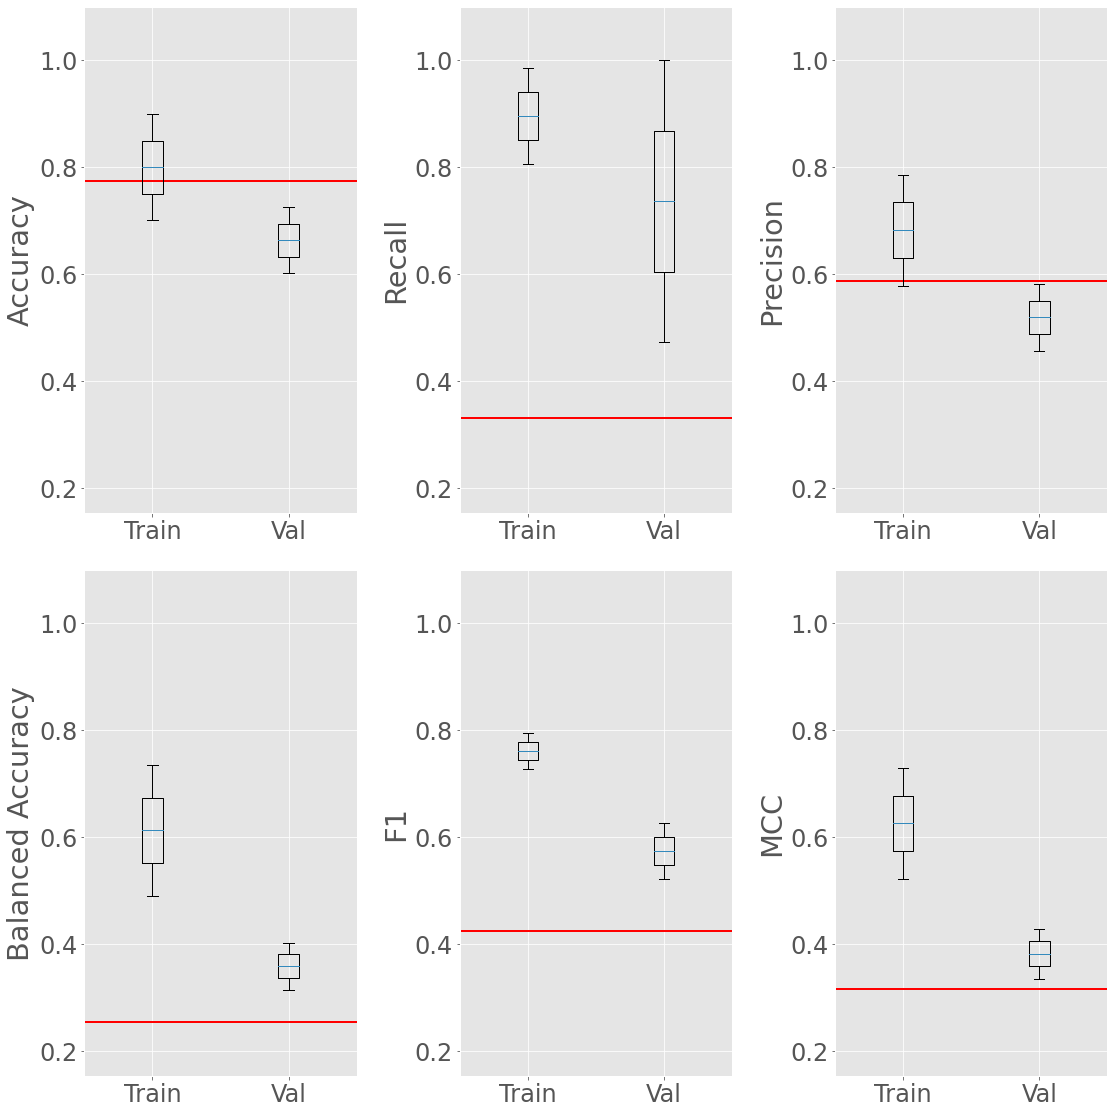

--------------> STARTING SPLIT 2 out of 2 <--------------
-----------> Calculating split 2/2 fold 1/2 <----------
---> MODEL FOR FINGERPRINTS
---> Trainig set fold 1
NER: 0.827, Sensitivity or recall: 0.932, Specificity: 0.722, Precision: 0.585, Correctly classified: 0.784, MCC: 0.598, F1 score: 0.719, Balanced accuracy: 0.654
---> Validation set fold 1
NER: 0.694, Sensitivity or recall: 0.760, Specificity: 0.629, Precision: 0.467, Correctly classified: 0.668, MCC: 0.356, F1 score: 0.579, Balanced accuracy: 0.389
---> MODEL FOR DESCRIPTORS
---> Trainig set fold 1
NER: 0.730, Sensitivity or recall: 0.608, Specificity: 0.852, Precision: 0.634, Correctly classified: 0.780, MCC: 0.466, F1 score: 0.621, Balanced accuracy: 0.460
---> Validation set fold 1
NER: 0.656, Sensitivity or recall: 0.507, Specificity: 0.806, Precision: 0.528, Correctly classified: 0.716, MCC: 0.316, F1 score: 0.517, Balanced accuracy: 0.312
---> COUPLED MODEL
-----> Coupled Training fold 1
Agreement_percentage_train 

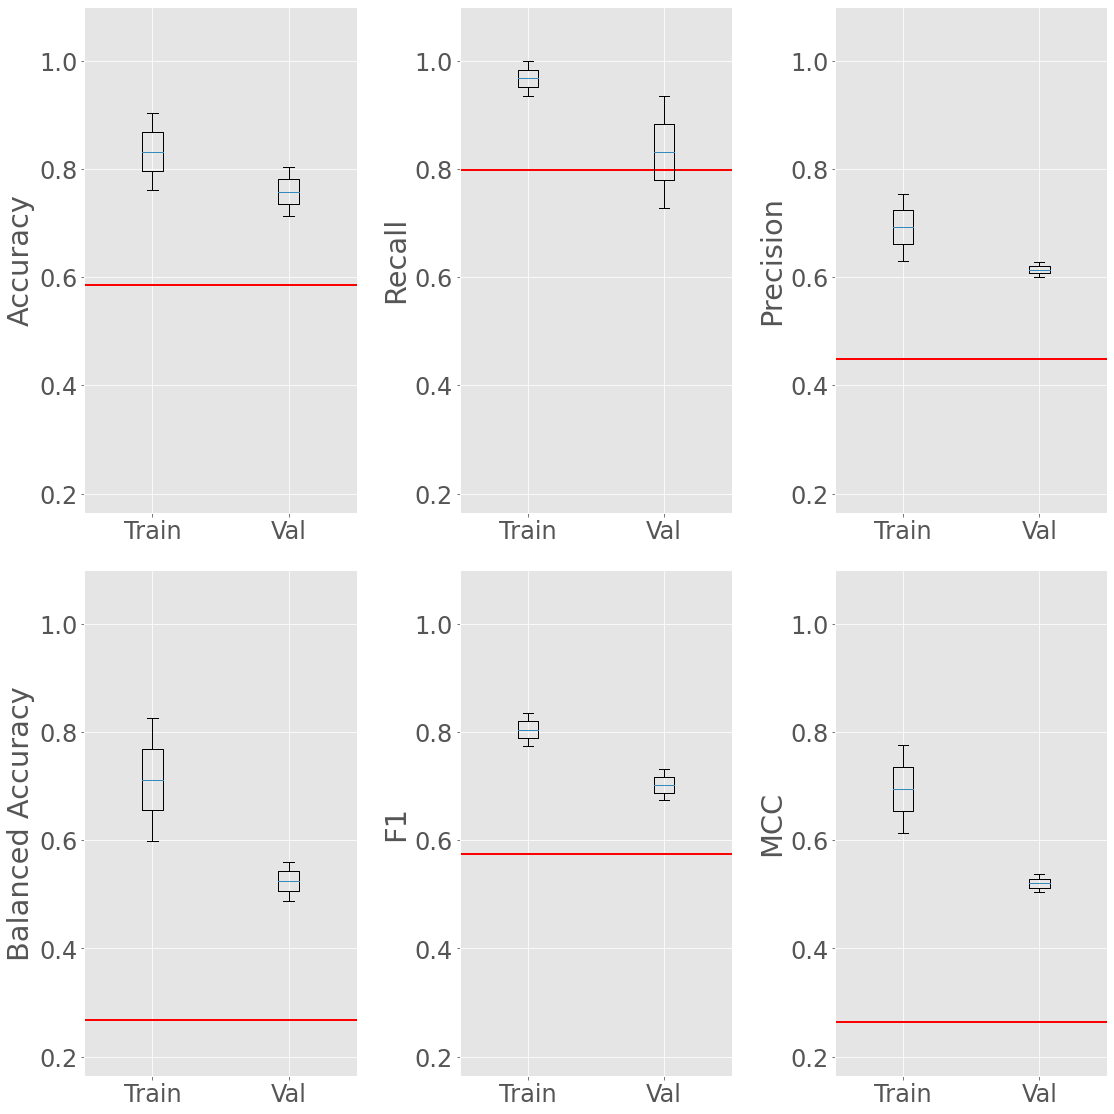

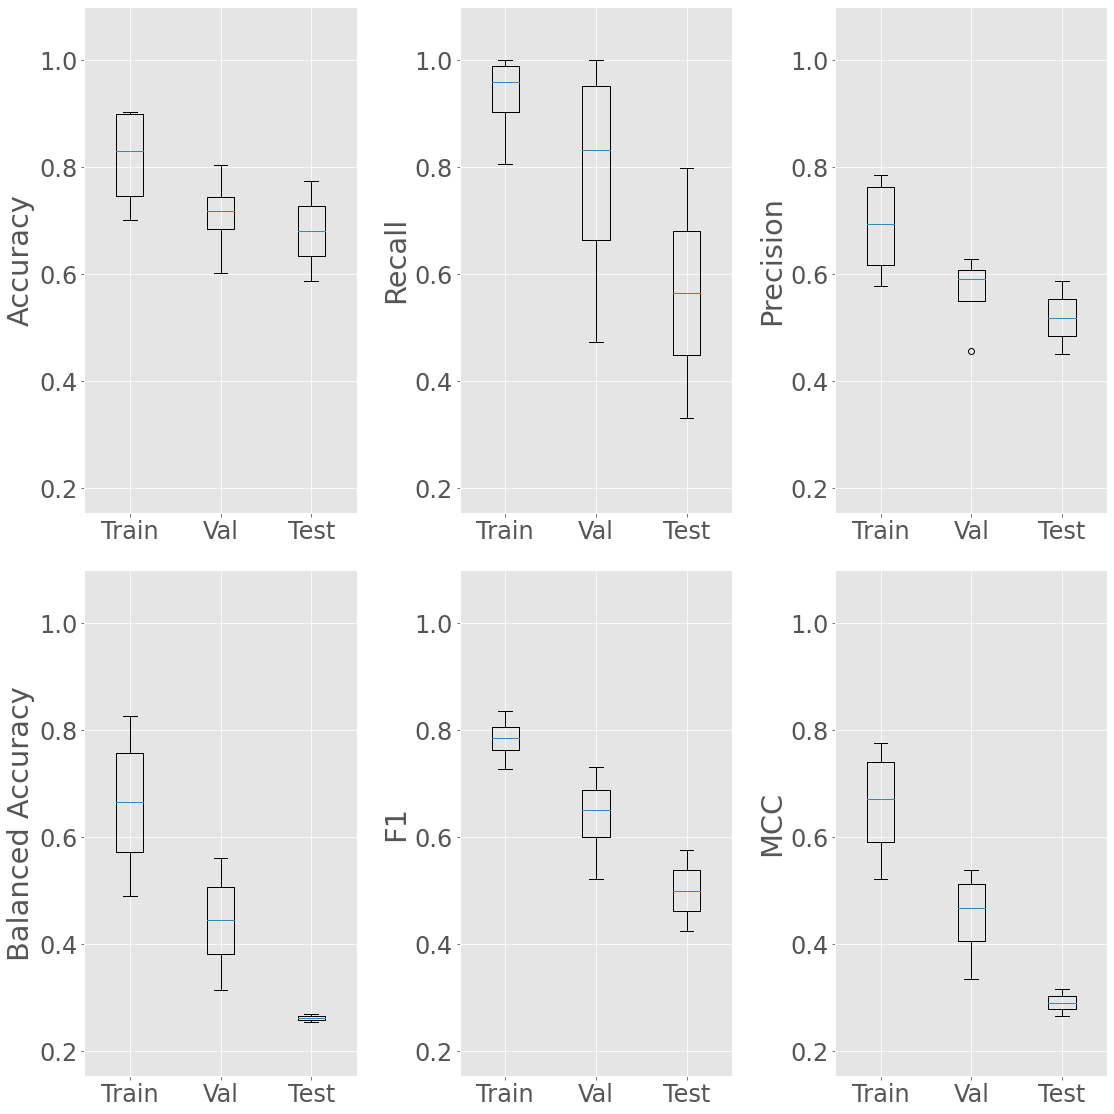

In [30]:
metrics_ls = ['MCC', 'acc', 'recall', 'precision', 'F1', 'balanced_acc']

for percetile_fingerprint, percetile_descriptors in percentil_com:
    
    if not coupled_NN:
        metrics_split = {'MCC_train': [], 'MCC_val': [], 'MCC_test': [], 'acc_train': [], 'acc_val': [], 'acc_test': [], 'recall_train': [], 'recall_val': [], 'recall_test': [],
                        'precision_train': [], 'precision_val': [], 'precision_test': [], 'F1_train': [], 'F1_val': [], 'F1_test': [], 'balanced_acc_train': [],
                        'balanced_acc_val': [], 'balanced_acc_test': []}
    else:
        # The two following dicts, will contain not relevant info, so they are removed after, the CV loop
        metrics_split_fp = {'MCC_train': [], 'MCC_val': [], 'MCC_test': [], 'acc_train': [], 'acc_val': [], 'acc_test': [], 'recall_train': [], 'recall_val': [], 'recall_test': [],
                        'precision_train': [], 'precision_val': [], 'precision_test': [], 'F1_train': [], 'F1_val': [], 'F1_test': [], 'balanced_acc_train': [],
                        'balanced_acc_val': [], 'balanced_acc_test': []}
        metrics_split_des = {'MCC_train': [], 'MCC_val': [], 'MCC_test': [], 'acc_train': [], 'acc_val': [], 'acc_test': [], 'recall_train': [], 'recall_val': [], 'recall_test': [],
                        'precision_train': [], 'precision_val': [], 'precision_test': [], 'F1_train': [], 'F1_val': [], 'F1_test': [], 'balanced_acc_train': [],
                        'balanced_acc_val': [], 'balanced_acc_test': []}
        # The following dict, will contain the metrics for the coupled NN
        metrics_split = {'MCC_train': [], 'MCC_val': [], 'MCC_test': [], 'acc_train': [], 'acc_val': [], 'acc_test': [], 'recall_train': [], 'recall_val': [], 'recall_test': [],
                        'precision_train': [], 'precision_val': [], 'precision_test': [], 'F1_train': [], 'F1_val': [], 'F1_test': [], 'balanced_acc_train': [],
                        'balanced_acc_val': [], 'balanced_acc_test': [], 'agreement_percentage_train':[], 'agreement_percentage_val':[], 'agreement_percentage_test':[]}
   
    for split, seed in enumerate(rand_num):
        rus = RandomUnderSampler(random_state=seed)
        print(f"--------------> STARTING SPLIT {split + 1} out of {num_train_val_splits} <--------------")
        if use_fingerprints:
            train_val_data_fp, _, train_val_labels_fp, _ = train_test_split(features_shared, labels_2c9,
                                                                            train_size=dataset_size, test_size=2,
                                                                            stratify=labels_2c9, random_state=seed)
            if balance_dataset:
                train_val_data_fp, train_val_labels_fp = rus.fit_resample(train_val_data_fp, train_val_labels_fp)
        if use_descriptors:
            train_val_data_des, _, train_val_labels_des, _ = train_test_split(norm_descriptors_shared, labels_2c9,
                                                                              train_size=dataset_size, test_size=2,
                                                                              stratify=labels_2c9, random_state=seed)
            if balance_dataset:
                train_val_data_des, train_val_labels_des = rus.fit_resample(train_val_data_des, train_val_labels_des)
        if use_descriptors and use_fingerprints:
            npt.assert_array_equal(train_val_labels_fp, train_val_labels_des,
                                   err_msg='Train labels do not coincide between descriptors and fingerprints.')
            assert train_val_data_fp.shape[0] == train_val_data_des.shape[0]

        best_features_split_fp, best_features_split_des = [], []
        skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
        
        if not coupled_NN:
            metrics_fold = {'MCC_train': [], 'MCC_val': [], 'acc_train': [], 'acc_val': [], 'recall_train': [], 'recall_val': [],
                        'precision_train': [], 'precision_val': [], 'F1_train': [], 'F1_val': [], 'balanced_acc_train': [],
                        'balanced_acc_val': []}
        else:
            # The two following dicts, will contain not relevant info, so they are removed after, the CV loop
            metrics_fold_fp = {'MCC_train': [], 'MCC_val': [], 'acc_train': [], 'acc_val': [], 'recall_train': [], 'recall_val': [],
                        'precision_train': [], 'precision_val': [], 'F1_train': [], 'F1_val': [], 'balanced_acc_train': [],
                        'balanced_acc_val': []}
            metrics_fold_des = {'MCC_train': [], 'MCC_val': [], 'acc_train': [], 'acc_val': [], 'recall_train': [], 'recall_val': [],
                        'precision_train': [], 'precision_val': [], 'F1_train': [], 'F1_val': [], 'balanced_acc_train': [],
                        'balanced_acc_val': []}
            # The following dict, will contain the metrics for the coupled NN
            metrics_fold = {'MCC_train': [], 'MCC_val': [], 'acc_train': [], 'acc_val': [], 'recall_train': [], 'recall_val': [],
                        'precision_train': [], 'precision_val': [], 'F1_train': [], 'F1_val': [], 'balanced_acc_train': [],
                        'balanced_acc_val': [], 'agreement_percentage_train':[], 'agreement_percentage_val':[]}
  
        for i, (train_index, val_index) in enumerate(skf.split(train_val_data_fp, train_val_labels_fp)): # TODO avoid error when only descriptors are used
            if use_fingerprints:
                train_data_fp, val_data_fp = train_val_data_fp[train_index], train_val_data_fp[val_index]
                train_labels_fp, val_labels_fp = train_val_labels_fp[train_index], train_val_labels_fp[val_index]
                data_fs_fp, best_fold_fp = get_best_features(train_data_fp, train_labels_fp, val_data_fp,
                                                             percetile_fingerprint)
                best_features_split_fp.extend(list(best_fold_fp))

                assert train_data_fp.shape[1] == val_data_fp.shape[1]
                assert train_data_fp.shape[0] == train_labels_fp.shape[0]
                assert val_data_fp.shape[0] == val_labels_fp.shape[0]
                assert best_fold_fp.shape[0] == data_fs_fp['train_data_fs'].shape[1]
                
                if not use_descriptors:  # to avoid conditional statements
                    train_data, val_data = data_fs_fp['train_data_fs'], data_fs_fp['val_data_fs']
                    train_labels, val_labels = train_labels_fp, val_labels_fp
                    model=model_fp[f'{FINGERPRINT}_{model_from_fp}']

            if use_descriptors:
                train_data_des, val_data_des = train_val_data_des[train_index], train_val_data_des[val_index]
                train_labels_des, val_labels_des = train_val_labels_des[train_index], train_val_labels_des[val_index]
                data_fs_des, best_fold_des = get_best_features(train_data_des, train_labels_des, val_data_des, percetile_descriptors)
                best_features_split_des.extend(list(best_fold_des))

                assert train_data_des.shape[1] == val_data_des.shape[1]
                assert train_data_des.shape[0] == train_labels_des.shape[0]
                assert val_data_des.shape[0] == val_labels_des.shape[0]
                assert best_fold_des.shape[0] == data_fs_des['train_data_fs'].shape[1]

                if not use_fingerprints:
                    train_data, val_data = data_fs_des['train_data_fs'], data_fs_des['val_data_fs']
                    train_labels, val_labels = train_labels_des, val_labels_des
                    model=model_des[f'{FINGERPRINT}_{model_from_des}']

            if use_descriptors and use_fingerprints:
                npt.assert_array_equal(train_labels_fp, train_labels_des,
                                       err_msg='Train labels do not coincide between descriptors and fingerprints.')
                npt.assert_array_equal(val_labels_fp, val_labels_des,
                                       err_msg='Validation labels do not coincide between descriptors and fingerprints.')
                assert data_fs_fp['train_data_fs'].shape[0] == data_fs_des['train_data_fs'].shape[0]
                assert data_fs_fp['val_data_fs'].shape[0] == data_fs_des['val_data_fs'].shape[0]

                train_labels, val_labels = train_labels_des, val_labels_des
                
                if not coupled_NN:
                    train_data = np.concatenate([data_fs_fp['train_data_fs'], data_fs_des['train_data_fs']], axis=1)
                    val_data = np.concatenate([data_fs_fp['val_data_fs'], data_fs_des['val_data_fs']], axis=1)
                    model = model_fp_des[f'{FINGERPRINT}_{DESCRIPTOR}_{model_from_des}']
                else:
                    train_data_fs_fp, val_data_fs_fp = data_fs_fp['train_data_fs'], data_fs_fp['val_data_fs']
                    train_data_fs_des, val_data_fs_des = data_fs_des['train_data_fs'], data_fs_des['val_data_fs']
                    train_labels, val_labels = train_labels_fp, val_labels_fp # since train_labels_fp = train_labels_des

            print(f"-----------> Calculating split {split + 1}/{num_train_val_splits} fold {i + 1}/{folds} <----------")
                
            if not coupled_NN:
                metrics_fold, pred_train, pred_val = training_model_CV(model, train_data, train_labels, val_data, val_labels, metrics_fold, fold=i, metrics_ls=metrics_ls)
            else:
                print(f"---> MODEL FOR FINGERPRINTS")
                metrics_fold_fp, pred_train_fp, pred_val_fp = training_model_CV(model_fp[f'{FINGERPRINT}_{model_from_fp}'], train_data_fs_fp, train_labels, val_data_fs_fp, val_labels, metrics_fold_fp, fold=i, metrics_ls=metrics_ls)
                print(f"---> MODEL FOR DESCRIPTORS")
                metrics_fold_des, pred_train_des, pred_val_des = training_model_CV(model_des[f'{DESCRIPTOR}_{model_from_des}'], train_data_fs_des, train_labels, val_data_fs_des, val_labels, metrics_fold_des, fold=i, metrics_ls=metrics_ls)
                
                pred_coupled_train, coincidences_train = get_coupled_prediction(pred_train_fp, pred_train_des)
                pred_coupled_val, coincidences_val = get_coupled_prediction(pred_val_fp, pred_val_des)
                
                agr_train = 100*len(train_labels[coincidences_train])/len(train_labels)
                agr_val = 100*len(val_labels[coincidences_val])/len(val_labels)

                print(f"---> COUPLED MODEL")
                print(f"-----> Coupled Training fold {i+1}")
                print(f"Agreement_percentage_train {agr_train}")
                dict_train = print_metrics(pred_coupled_train, train_labels[coincidences_train])
                print(f"-----> Coupled Validation fold {i+1}")
                print(f"Agreement_percentage_val {agr_val}")
                dict_val = print_metrics(pred_coupled_val, val_labels[coincidences_val])
                
                # New parameter!
                metrics_fold['agreement_percentage_train'].append(100*len(train_labels[coincidences_train])/len(train_labels))
                metrics_fold['agreement_percentage_val'].append(100*len(val_labels[coincidences_val])/len(val_labels))
                
                metrics_fold = append_metrics_to_dict(metrics_fold, 'train', dict_train, 'val', dict_val, metrics_ls=metrics_ls)

                del dict_train, dict_val, agr_train, agr_val
                
        if use_fingerprints:
            best_feat_CV_fp = find_best_features(best_features_split_fp, data_fs_fp['train_data_fs'].shape[1])
            train_val_data_fp = np.concatenate([train_data_fp, val_data_fp], axis=0)

            assert train_val_data_fp.shape[0] == train_data_fp.shape[0] + val_data_fp.shape[0]
            assert train_val_data_fp.shape[1] == train_data_fp.shape[1]

            print(train_val_data_fp.shape, len(best_feat_CV_fp), data_fs_fp['train_data_fs'].shape[1])
            train_val_data_fs_fp = train_val_data_fp[:, best_feat_CV_fp]
            test_data_fp = features_only_2c9[:, best_feat_CV_fp]

            if not use_descriptors:
                labels_split = np.concatenate([train_labels_fp, val_labels_fp], axis=0)
                train_val_data_fs = train_val_data_fs_fp
                test_data = test_data_fp

        if use_descriptors:
            best_feat_CV_des = find_best_features(best_features_split_des, data_fs_des['train_data_fs'].shape[1])
            train_val_data_des = np.concatenate([train_data_des, val_data_des], axis=0)

            assert train_val_data_des.shape[0] == train_data_des.shape[0] + val_data_des.shape[0]
            assert train_val_data_des.shape[1] == train_data_des.shape[1]

            train_val_data_fs_des = train_val_data_des[:, best_feat_CV_des]
            test_data_des = norm_descriptors_only2c9[:, best_feat_CV_des]

            if not use_fingerprints:
                labels_split = np.concatenate([train_labels_des, val_labels_des], axis=0)
                train_val_data_fs = train_val_data_fs_des
                test_data = test_data_des

        if use_fingerprints and use_descriptors:
            labels_split = np.concatenate([train_labels_fp, val_labels_fp], axis=0)
            if not coupled_NN:
                train_val_data_fs = np.concatenate([train_val_data_fs_fp, train_val_data_fs_des], axis=1)
                test_data = np.concatenate([test_data_fp, test_data_des], axis=1)
            else:
                del metrics_fold_fp, metrics_fold_des

        
        if not coupled_NN:
            metrics_split, dict_test, _ = train_predict_test(model, train_val_data_fs, labels_split, test_data, labels_testing_2c9, metrics_split, split = split)
            metrics_split = append_metrics_to_dict(metrics_split, 'train', metrics_fold, 'val', metrics_fold, metrics_ls=metrics_ls)
        else:
            print(f"---> MODEL FOR FINGERPRINTS")
            metrics_split_fp, _, pred_test_fp = train_predict_test(model_fp[f'{FINGERPRINT}_{model_from_fp}'], train_val_data_fs_fp, labels_split, test_data_fp, labels_testing_2c9, metrics_split_fp, split = split)
            print(f"---> MODEL FOR DESCRIPTORS")
            metrics_split_des, _, pred_test_des = train_predict_test(model_des[f'{DESCRIPTOR}_{model_from_des}'], train_val_data_fs_des, labels_split, test_data_des, labels_testing_2c9, metrics_split_des, split = split)

            pred_coupled_test, coincidences_test = get_coupled_prediction(pred_test_fp, pred_test_des)
            
            dict_test = print_metrics(pred_coupled_test, labels_testing_2c9[coincidences_test])
           
            metrics_split = append_metrics_to_dict(metrics_split, 'test', dict_test, None, None, metrics_ls=metrics_ls)
            metrics_split['agreement_percentage_test'].append(100*len(labels_testing_2c9[coincidences_test])/len(labels_testing_2c9))
            
            metrics_split = append_metrics_to_dict(metrics_split, 'train', metrics_fold, 'val', metrics_fold, metrics_ls=metrics_ls+['agreement_percentage']) # No se si això funcionara de la metric_ls
            
        plot_results_CV(metrics_fold['MCC_train'], metrics_fold['MCC_val'], metrics_fold['acc_train'], metrics_fold['acc_val'], metrics_fold['recall_train'], metrics_fold['recall_val'], metrics_fold['precision_train'],
                        metrics_fold['precision_val'], metrics_fold['F1_train'], metrics_fold['F1_val'], metrics_fold['balanced_acc_train'], metrics_fold['balanced_acc_val'], dict_test['acc'], dict_test['MCC'],
                        dict_test['recall'], dict_test['precision'], dict_test['F1'], dict_test['balanced_acc'],
                        filename=f'{PATH_CV_results}{percetile_fingerprint}-{percetile_descriptors}_fp-des_split{split + 1}')

    plot_results_split(metrics_split['MCC_train'], metrics_split['MCC_val'], metrics_split['acc_train'], metrics_split['acc_val'], metrics_split['recall_train'], metrics_split['recall_val'], metrics_split['precision_train'],
                       metrics_split['precision_val'], metrics_split['F1_train'], metrics_split['F1_val'], metrics_split['balanced_acc_train'], metrics_split['balanced_acc_val'], metrics_split['MCC_test'], metrics_split['acc_test'],
                       metrics_split['recall_test'], metrics_split['precision_test'], metrics_split['F1_test'], metrics_split['balanced_acc_test'],
                      filename=f'{PATH_CV_results}Average_{percetile_fingerprint}-{percetile_descriptors}_fp-des.png')

    if not coupled_NN:
        df[f'{percetile_fingerprint}:{percetile_descriptors}'] = [np.nanmean( metrics_split['MCC_val']), np.nanstd( metrics_split['MCC_val']), np.nanmean(metrics_split['acc_val']) , np.nanstd(metrics_split['acc_val']) , np.nanmean(metrics_split['recall_val']), np.nanstd(metrics_split['recall_val']), np.nanmean(metrics_split['precision_val']), np.nanstd(metrics_split['precision_val']) , np.nanmean(metrics_split['F1_val']), np.nanstd(metrics_split['F1_val']) , np.nanmean(metrics_split['balanced_acc_val']) , np.nanstd(metrics_split['balanced_acc_val']),
                                                                  np.nanmean( metrics_split['MCC_test']), np.nanstd(metrics_split['MCC_test']), np.nanmean(metrics_split['acc_test']) , np.nanstd(metrics_split['acc_test']) , np.nanmean(metrics_split['recall_test']), np.nanstd(metrics_split['recall_test']), np.nanmean(metrics_split['precision_test']), np.nanstd(metrics_split['precision_test']) , np.nanmean(metrics_split['F1_test']), np.nanstd(metrics_split['F1_test']) , np.nanmean(metrics_split['balanced_acc_test']) , np.nanstd(metrics_split['balanced_acc_test'])]
    else:
        df[f'{percetile_fingerprint}:{percetile_descriptors}'] = [np.nanmean( metrics_split['MCC_val']), np.nanstd( metrics_split['MCC_val']), np.nanmean(metrics_split['acc_val']) , np.nanstd(metrics_split['acc_val']) , np.nanmean(metrics_split['recall_val']), np.nanstd(metrics_split['recall_val']), np.nanmean(metrics_split['precision_val']), np.nanstd(metrics_split['precision_val']) , np.nanmean(metrics_split['F1_val']), np.nanstd(metrics_split['F1_val']) , np.nanmean(metrics_split['balanced_acc_val']) , np.nanstd(metrics_split['balanced_acc_val']),
                                                                  np.nanmean( metrics_split['MCC_test']), np.nanstd(metrics_split['MCC_test']), np.nanmean(metrics_split['acc_test']) , np.nanstd(metrics_split['acc_test']) , np.nanmean(metrics_split['recall_test']), np.nanstd(metrics_split['recall_test']), np.nanmean(metrics_split['precision_test']), np.nanstd(metrics_split['precision_test']) , np.nanmean(metrics_split['F1_test']), np.nanstd(metrics_split['F1_test']) , np.nanmean(metrics_split['balanced_acc_test']) , np.nanstd(metrics_split['balanced_acc_test']),
                                                                  np.nanmean( metrics_split['agreement_percentage_val']), np.nanstd( metrics_split['agreement_percentage_val']), np.nanmean( metrics_split['agreement_percentage_test']), np.nanstd( metrics_split['agreement_percentage_test'])]
    
    df.to_csv(f'{PATH_SAVE}metrics_average_diff_percentile.csv', index=True) #To read this file do -> df = pd.read_csv('path/metrics_average_diff_percentile.csv', index_col=0)

